In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd

# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/RansomwareData.csv')


Mounted at /content/drive/


In [ ]:
X = df.drop(df.columns[0], axis=1)
X = X.drop(df.columns[1], axis=1)
X = X.drop(df.columns[2], axis=1)
y = df[df.columns[2]]

y_binary = df[df.columns[1]]

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Apply the grouping function to the multi-class labels
y_group = y.apply(convert_to_group)

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume df is your DataFrame and contains your data
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit K-means with the desired number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# One-hot encode cluster labels if desired
cluster_labels_one_hot = tf.keras.utils.to_categorical(cluster_labels)

# Concatenate the cluster labels with the original features
X_w_clusters = np.hstack((X, cluster_labels_one_hot))

# Update the input shape
input_shape_with_clusters = X_w_clusters.shape[1]

from sklearn.model_selection import train_test_split
X_with_clusters, X_test_with_clusters, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X_w_clusters, y, y_binary, y_group, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:

from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

# Ensure input dimensions are correct
encoding_dim = X_with_clusters.shape[1]

# Input layer
input_layer = Input(shape=(encoding_dim,))

# Shared layers
x = Dense(64, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)  # Fixed duplicate use of input_layer

# Binary Classification Head (Goodware vs Malicious)
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)

# Group Classification Head
group_output = Dense(4, activation='softmax', name='group_output')(x)

# Specific Classification Head
specific_output = Dense(12, activation='softmax', name='specific_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[binary_output, group_output, specific_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'group_output': 'categorical_crossentropy', 'specific_output': 'categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Summary of the model
model.summary()

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
label_to_group = {
    0: 0,  # Goodware
    1: 1,  # Critroni
    2: 1,  # CryptLocker
    3: 1,  # CryptoWall
    4: 2,  # KOLLAH
    5: 2,  # Kovter
    6: 2,  # Locker
    7: 3,  # MATSNU
    8: 3,  # PGPCODER
    9: 3,  # Reveton
    10: 3,  # TeslaCrypt
    11: 3,  # Trojan-Ransom
}
# Assuming y_train and y_test are pandas Series
y_train_group = y_train.map(label_to_group)
y_test_group = y_test.map(label_to_group)

# Binary labels (Goodware vs Malicious)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

# One-hot encode the group and specific labels
y_train_group_categorical = to_categorical(y_train_group, num_classes=4)
y_train_categorical = to_categorical(y_train, num_classes=12)
y_test_group_categorical = to_categorical(y_test_group, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=12)

# Train the model
history = model.fit(X_with_clusters,
                    {'binary_output': y_train_binary, 'group_output': y_train_group_categorical, 'specific_output': y_train_categorical},
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_test_with_clusters, {'binary_output': y_test_binary, 'group_output': y_test_group_categorical, 'specific_output': y_test_categorical}),
                    callbacks=[early_stopping])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30971)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      1,982,208 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          4,160 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ binary_output (Dense)     │ (None, 1)              │             65 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_output (Dense)      │ (None, 4)              │            260 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ specific_output (Dense)   │ (None, 12)             │            780 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,987,473 (7.58 MB)

 Trainable params: 1,987,473 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - binary_output_accuracy: 0.7786 - group_output_accuracy: 0.6713 - loss: 2.6173 - specific_output_accuracy: 0.5790 - val_binary_output_accuracy: 0.9311 - val_group_output_accuracy: 0.8164 - val_loss: 1.4818 - val_specific_output_accuracy: 0.7607
Epoch 2/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - binary_output_accuracy: 0.9809 - group_output_accuracy: 0.8575 - loss: 1.0706 - specific_output_accuracy: 0.8115 - val_binary_output_accuracy: 0.9672 - val_group_output_accuracy: 0.8426 - val_loss: 1.2071 - val_specific_output_accuracy: 0.7836
Epoch 3/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - binary_output_accuracy: 0.9930 - group_output_accuracy: 0.9264 - loss: 0.6370 - specific_output_accuracy: 0.8764 - val_binary_output_accuracy: 0.9639 - val_group_output_accuracy: 0.8689 - val_loss: 1.1112 - val_specific_output_accuracy: 0.8328
Epoch 4/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - binary_output_accuracy: 0.9856 - group_ou

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions on the test set
test_predictions = model.predict(X_test_with_clusters)

# Binary predictions and metrics
binary_predictions = (test_predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)

# Specific predictions and metrics
specific_predictions = np.argmax(test_predictions[2], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Binary Classification Metrics:
Accuracy: 0.9770
Precision: 0.9741
Recall: 0.9658
F1 Score: 0.9700

Specific Classification Metrics:
Accuracy: 0.8361
Precision: 0.5671
Recall: 0.4811
F1 Score: 0.4931


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


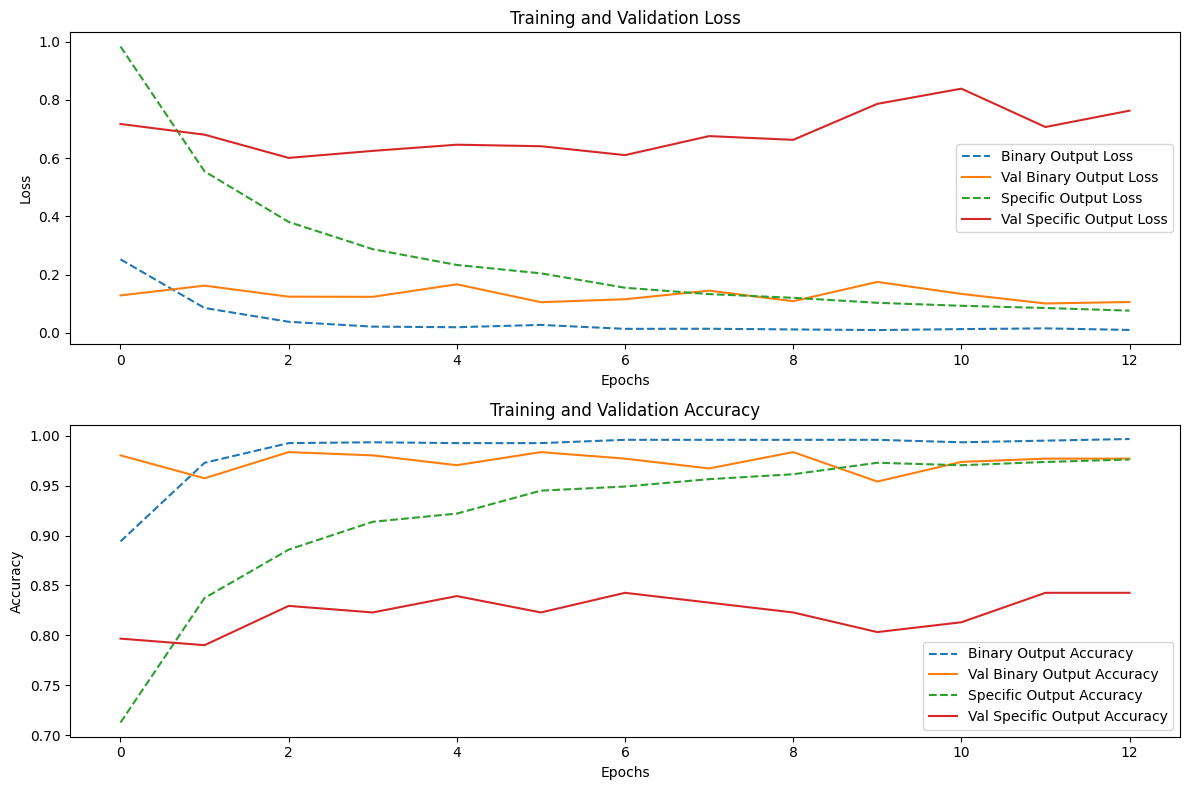

In [ ]:
import matplotlib.pyplot as plt

# Extract the history for each output
binary_loss = history.history['binary_output_loss']
val_binary_loss = history.history['val_binary_output_loss']
specific_loss = history.history['specific_output_loss']
val_specific_loss = history.history['val_specific_output_loss']

binary_acc = history.history['binary_output_accuracy']
val_binary_acc = history.history['val_binary_output_accuracy']
specific_acc = history.history['specific_output_accuracy']
val_specific_acc = history.history['val_specific_output_accuracy']

# Plot loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(binary_loss, linestyle='--', label='Binary Output Loss')
plt.plot(val_binary_loss, label='Val Binary Output Loss')
plt.plot(specific_loss, linestyle='--', label='Specific Output Loss')
plt.plot(val_specific_loss, label='Val Specific Output Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(binary_acc, linestyle='--', label='Binary Output Accuracy')
plt.plot(val_binary_acc, label='Val Binary Output Accuracy')
plt.plot(specific_acc, linestyle='--', label='Specific Output Accuracy')
plt.plot(val_specific_acc, label='Val Specific Output Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 [==============================] - 0s 17ms/step


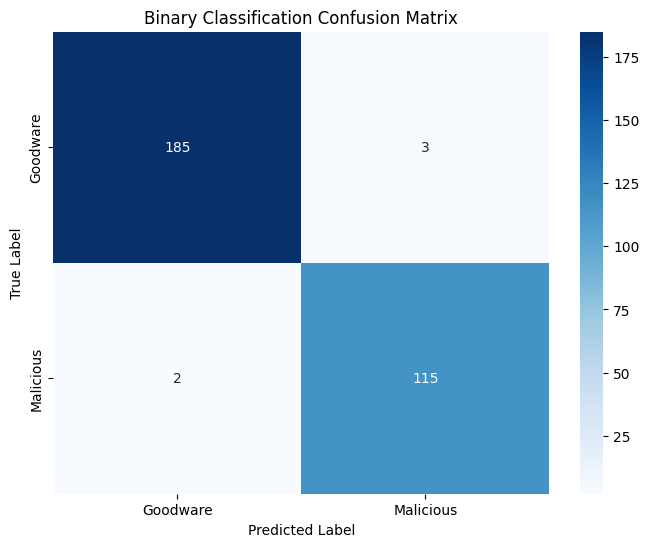

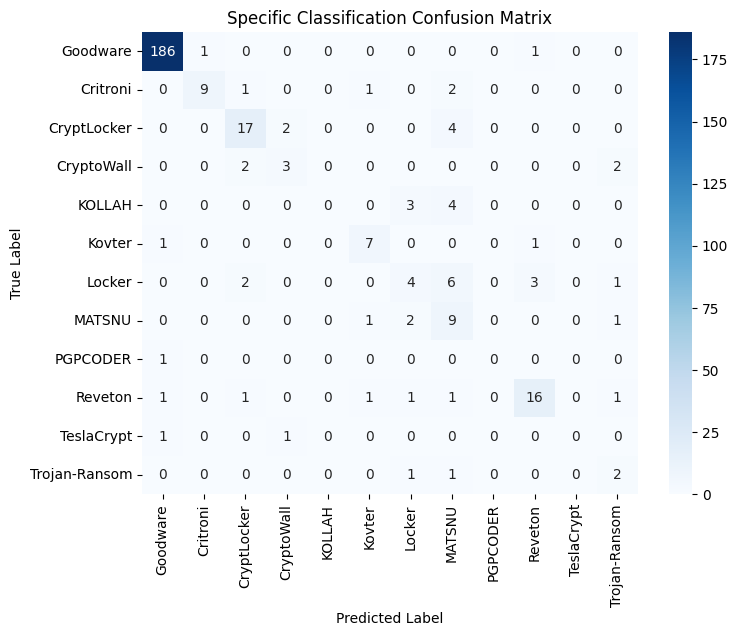

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on the test set
predictions = model.predict(X_test_with_clusters)

# Binary classification confusion matrix
binary_preds = np.round(predictions[0]).astype(int)
binary_cm = confusion_matrix(y_test_binary, binary_preds)

# Specific classification confusion matrix
specific_preds = np.argmax(predictions[1], axis=1)
specific_cm = confusion_matrix(y_test, specific_preds)

# Plot confusion matrices
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot Binary classification confusion matrix
plot_confusion_matrix(binary_cm, classes=['Goodware', 'Malicious'], title='Binary Classification Confusion Matrix')


# Plot Specific classification confusion matrix
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
plot_confusion_matrix(specific_cm, classes=specific_labels, title='Specific Classification Confusion Matrix')


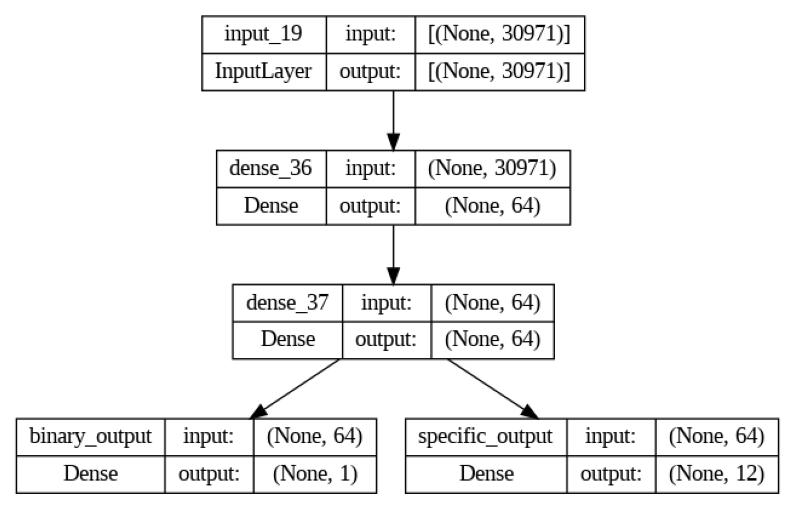

In [ ]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
# Plot the model
plot_model(model, to_file='dnn_model.png', show_shapes=True, show_layer_names=True)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display the model
img = mpimg.imread('dnn_model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
